# Project 1.1 Create an MLP with one hidden layer. 

Explore how the performance is affected by varying the number of neurons in the hidden layer and test your model against a binary classification task.

* Use the MLP class we used in the tutorial.
* Dataset: 0 and 1 digits from MNIST dataset.
* Vary the number of hidden neurons and plot the accuracy as a function of the number of neurons in the hidden layers.
* Redo the previous steps by changing the activation functions.


In [83]:
# import packages

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from keras.datasets import mnist

import time

In [84]:
# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Subsetting the data
# print([(y_train == 0) | (y_train == 1)])                # This returns an boolean array with True for indices where value is 0 or 1


# Filter the training data to only include 0s and 1s
X_train = X_train[(y_train == 0) | (y_train == 1)]
y_train = y_train[(y_train == 0) | (y_train == 1)]

# Filter the test data to only include 0s and 1s
X_test = X_test[(y_test == 0) | (y_test == 1)]
y_test = y_test[(y_test == 0) | (y_test == 1)]

# check the number of images
len(X_train), len(y_train)

(12665, 12665)

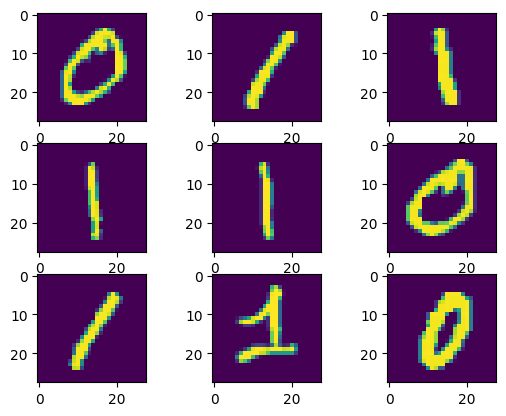

In [85]:
for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i])

plt.show()

In [86]:
# define the activation functions to try

def heaviside(x, theta, derivative = False):
    if derivative:
        return np.ones_like(x)
    return np.where(x >= theta, 1, 0)

def sigmoid(x, derivative = False):
    if derivative:
        return sigmoid(x) * (1 - sigmoid(x))
    return 1 / (1 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        return 1 - np.square(tanh(x))
    return np.tanh(x)

def relu(x, derivative = False):
    if derivative:
        return np.where(x >= 0, 1, 0)
    return np.maximum(x, 0)

In [87]:
# define the error function

def squared_error(prediction, target, derivative=False):
    if derivative:
        return -2*(target - prediction)
    return np.square(target - prediction)

In [90]:
# define class for perceptron

class MLP:
    def __init__(self, input_size, hidden_size, activation_function, loss_function, **kwargs):
        self.weights_h                      = np.random.randn(hidden_size, input_size)*0.001
        self.weights_o                      = np.random.randn(1, hidden_size)*0.001
        self.bias_h                         = np.ones((hidden_size, 1))
        self.bias_o                         = 0.0
        self.activation_function            = activation_function
        self.threshold                      = kwargs.get("threshold", 0)
        self.loss_function                  = loss_function
        
        
    def forward(self, weights, bias, layer_input):
        pre_activation = weights @ layer_input + bias
        if self.activation_function == heaviside:
            layer_output = self.activation_function(pre_activation, theta = self.threshold)
        else:
            layer_output = self.activation_function(pre_activation)
            
        return pre_activation, layer_output
    
    def train(self, input, targets, learning_rate, epochs):
        self.loss = []
        
        for epoch in range(epochs):
            error = 0
            
            for i in range(len(input)):
                
                x_ = input[i].flatten().reshape(-1, 1)
                # forward pass
                z_h, a_h = self.forward(self.weights_h, self.bias_h, x_)                # input to hidden
                z_o, a_o = self.forward(self.weights_o, self.bias_o, a_h)               # hidden to output
                
                # compute the error signal
                error += self.loss_function(prediction=a_o, target=targets[i])
                
                # compute the gradient of the loss
                grad_loss = self.loss_function(prediction=a_o, target=targets[i], derivative = True)
                
                # compute the gradient of activation function
                if self.activation_function == heaviside:
                    grad_act_function = self.activation_function(a_o, theta = self.threshold, derivative = True)
                else:
                    grad_act_function = self.activation_function(a_o, derivative = True)
                    
                # derivative of the activation function to the output layer i.e. weights between hidden and output layer
                dz_o = grad_loss * grad_act_function
                
                # update the weights
                self.weights_o -= learning_rate * dz_o @ a_h.T
                self.bias_o    -= learning_rate * dz_o 
                
                # now we are done with the first part of the backwrd pass (output --> hidden)
                
                # compute the gradient of you activation function
                if self.activation_function == heaviside:
                    grad_act_function = self.activation_function(z_h, theta=self.threshold, derivative=True)
                else:
                    grad_act_function = self.activation_function(z_h, derivative=True)
                    
                # derivative of the activation function the the hidden layer i.e. weights between input and hidden layer
                # print(self.weights_o)
                dz_h = self.weights_o.T @ dz_o * grad_act_function
                # print(f'self.weights_o.T: {self.weights_o.T.shape}, dz_o: {dz_o.shape}')
                
                # print(f'dz_h {dz_h.shape}')
                # update the weights and bias
                
                # print(f'dz_h: {dz_h.shape}, x: {x_.shape}, x_.T: {x_.T.shape}')
                self.weights_h  -= learning_rate * dz_h @ x_.T
                self.bias_h     -= learning_rate * dz_h
                
            # comput the loss
            self.loss.append(float(error/len(input)))  
            
            # print(f"Epoch {epoch} --> Loss: {float(error/len(input))}")    
    
    
    def evaluate(self, inputs):
        predictions = []
        for i in range(len(inputs)):
            x_ = inputs[i].flatten().reshape(-1, 1)
            z_h, a_h = self.forward(self.weights_h, self.bias_h, x_)
            z_o, a_o = self.forward(self.weights_o, self.bias_o, a_h)
            predictions.append(a_o.item())
        return np.array(predictions)
            
    def test(self, input, labels):
        predictions = []
        for i in range(len(input)):
            x_ = input[i].reshape(-1, 1)
            z_h, a_h = self.forward(self.weights_h, self.bias_h, x_)
            z_o, a_o = self.forward(self.weights_o, self.bias_o, a_h)
            pred = a_o.item()
            
            if self.activation_function == tanh or self.activation_function == relu:
                theta = 0
            elif self.activation_function == heaviside:
                theta = labels[i]
            else:
                theta = 0.5
            
            
            if pred >= theta:
                predictions.append(1)
            else:
                predictions.append(0)    
        
        accuracy = sum(predictions)/len(predictions)   
        return accuracy

In [91]:
perceptron_heaviside = MLP(input_size = 784, hidden_size = 30, threshold = 0, activation_function= heaviside, loss_function=squared_error)

# train 
perceptron_heaviside.train(X_train[:100], y_train[:100], 0.001, 10)

accuracy = perceptron_heaviside.test(X_test, y_test)

print("=============================")
print(f'\nAccuracy: {accuracy * 100:.2f}%')


Accuracy: 97.87%


In [60]:
# How does the amount of training data affect the accuracy of the model?

data_amount = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 400]

accuracies = []

perceptron_heaviside = MLP(input_size = 784, hidden_size = 10, threshold = 0, activation_function= heaviside, loss_function=squared_error) 

for amount in data_amount:
    perceptron_heaviside.train(X_train[:amount], y_train[:amount], 0.001, 10)
    accuracy = perceptron_heaviside.test(X_test, y_test)
    accuracies.append(accuracy)

In [61]:
accuracies

[0.46335697399527187,
 0.5829787234042553,
 0.5366430260047281,
 0.8505910165484634,
 0.8576832151300237,
 0.5366430260047281,
 0.9134751773049645,
 0.9281323877068558,
 0.9371158392434988,
 0.5366430260047281,
 0.9432624113475178,
 0.9508274231678487,
 0.9574468085106383,
 0.9787234042553191]

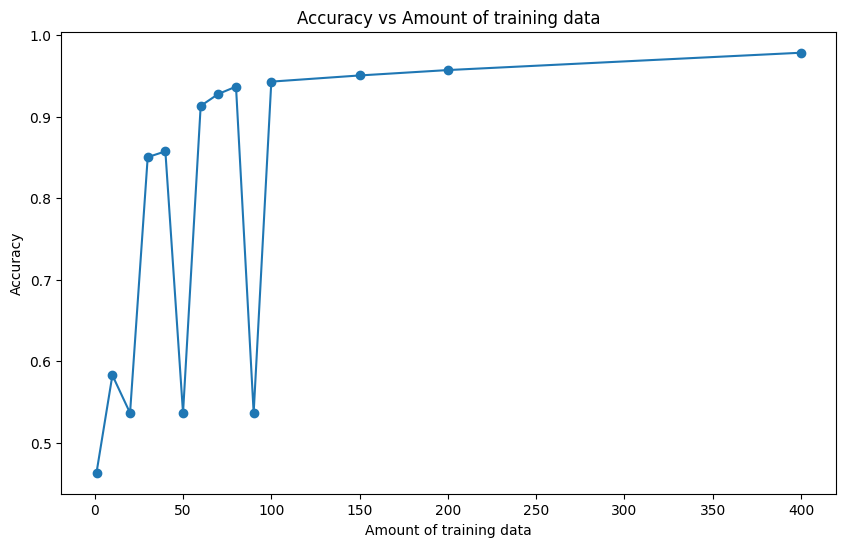

In [62]:
# plot the accuracies really nice
plt.figure(figsize=(10, 6))
plt.plot(data_amount, accuracies, 'o-')
plt.xlabel('Amount of training data')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Amount of training data')
plt.show()

In [77]:
# how does the number of hidden units affect the accuracy of the model?

hidden_units = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
accuracies = []

for unit in hidden_units:
    perceptron_heaviside = MLP(input_size = 784, hidden_size = unit, threshold = 0, activation_function= heaviside, loss_function=squared_error) 
    perceptron_heaviside.train(X_train[:20], y_train[:20], 0.0001, 10)
    accuracy = perceptron_heaviside.test(X_test[:20], y_test[:20])
    accuracies.append(accuracy)

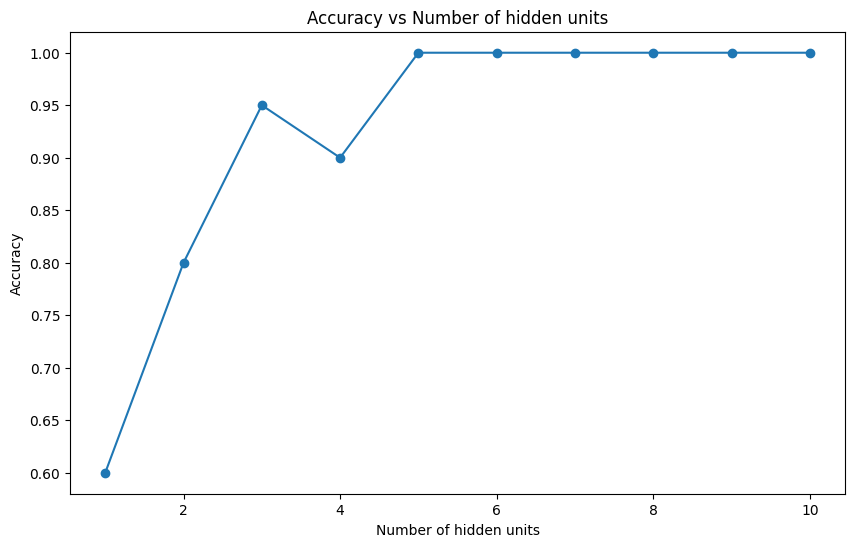

In [78]:
# plot the accuracies really nice
plt.figure(figsize=(10, 6))
plt.plot(hidden_units, accuracies, 'o-')
plt.xlabel('Number of hidden units')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of hidden units')
plt.show()

In [94]:
hidden_sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 20]
activation_functions = [heaviside, sigmoid, tanh, relu]
performance = {'heaviside': [], 'sigmoid': [], 'tanh': [], 'relu': []}

for activation_function in activation_functions:
    for hidden_size in hidden_sizes:
        perceptron = MLP(input_size = 784, hidden_size = hidden_size, threshold = 0, activation_function= activation_function, loss_function=squared_error)
        perceptron.train(X_train[:20], y_train[:20], 0.0001, 5)
        accuracy = perceptron.test(X_test, y_test)
        performance[activation_function.__name__].append(accuracy)

print(performance)
    # print(f'Accuracy with {hidden_size} neurons in hidden layer: {accuracy * 100:.2f}%\n')


{'heaviside': [1.0, 1.0, 0.991016548463357, 0.8836879432624114, 0.9929078014184397, 0.9905437352245863, 0.956501182033097, 0.9825059101654846, 0.9966903073286052, 0.9787234042553191], 'sigmoid': [0.4955082742316785, 0.01938534278959811, 0.31678486997635935, 0.9730496453900709, 1.0, 1.0, 0.0, 0.3177304964539007, 1.0, 0.6217494089834515], 'tanh': [0.9995271867612293, 0.8817966903073287, 1.0, 0.9995271867612293, 1.0, 0.9985815602836879, 1.0, 1.0, 0.9962174940898345, 0.9952718676122931], 'relu': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}


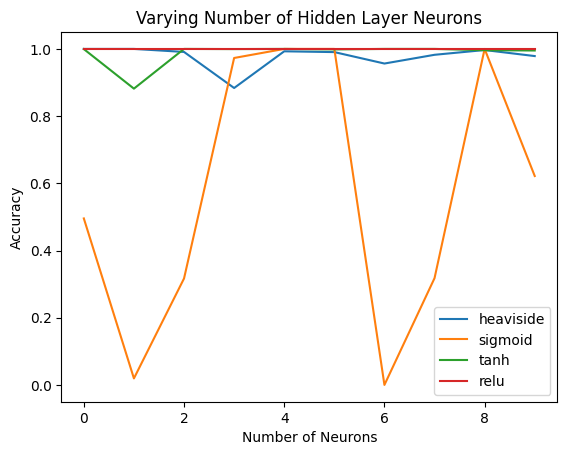

In [96]:
# plot the accuracies really nice and include a legend
plt.plot(performance['heaviside'])
plt.plot(performance['sigmoid'])
plt.plot(performance['tanh'])
plt.plot(performance['relu'])
plt.legend(['heaviside', 'sigmoid', 'tanh', 'relu'])
plt.xlabel('Number of Neurons')
plt.ylabel('Accuracy')
plt.title('Varying Number of Hidden Layer Neurons')
plt.show()